<a href="https://colab.research.google.com/github/FlorianGelb/GNNProject/blob/K_sparse/Evaluation_for_k_SAE_noisedata_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
import numpy as np


%matplotlib inline

In [ ]:
from K_SAE import Net,plot

In [ ]:
sequence = [50 - 5 * i for i in range(10)]
layers=[28*28,128,64,50]
models_MNIST={str(k): Net(layers,k) for k in sequence}
models_FashionMNIST={str(k): Net(layers,k) for k in sequence}

In [ ]:
for k in models_MNIST:
    checkpoint = torch.load(f'MINST_weights_{k}_Relu_128*64*50.pth')
    models_MNIST[k].load_state_dict(checkpoint)

    checkpoint = torch.load(f'FashionMINST_weights_{k}_Relu.pth')
    models_FashionMNIST[k].load_state_dict(checkpoint)


In [ ]:

transform = transforms.ToTensor()
class FMDataset(Dataset):
    def __init__(self,dataframe,root_dir,transform=None):
        self.dataframe=dataframe
        self.root_dir = root_dir
        self.transform=transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self,idx):
        img_name=os.path.join(self.root_dir,self.dataframe.iloc[idx,0])
        image=Image.open(img_name)
        label=self.dataframe.iloc[idx,1]
        if self.transform:
            image=self.transform(image)
        return image,label

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
import Corruption.corruptions as c
import csv
from PIL import Image
import os
import uuid
from tqdm import tqdm

In [ ]:

root_dir = 'CorruptedMNIST'
data = pd.read_csv('CorruptedMNIST/Names.csv')
dataset = FMDataset(dataframe=data,root_dir=root_dir,transform=transform)


In [ ]:
train_dataset, test_dataset = random_split(dataset, [58000, 2000])
test_loader = DataLoader(test_dataset, batch_size=64)

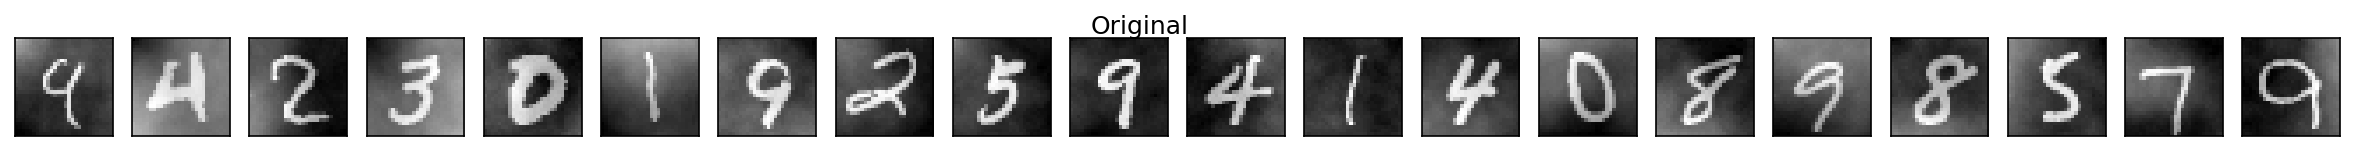

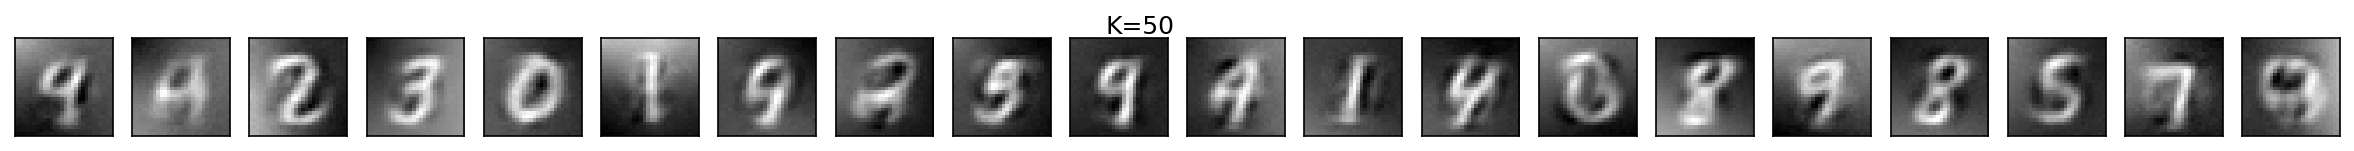

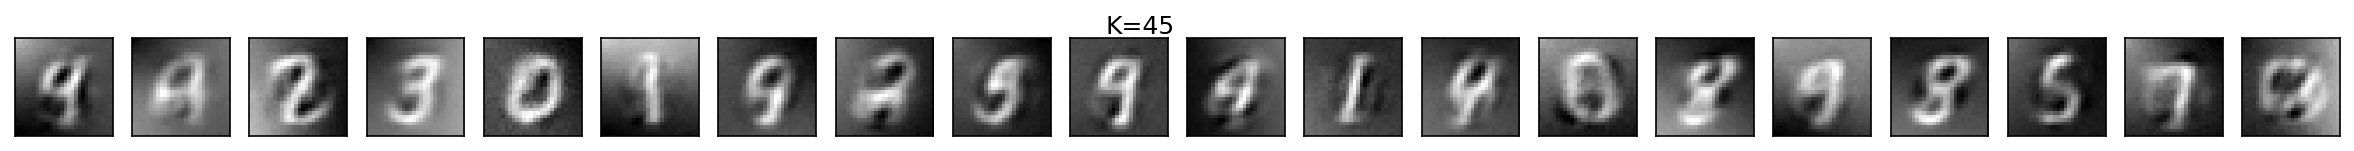

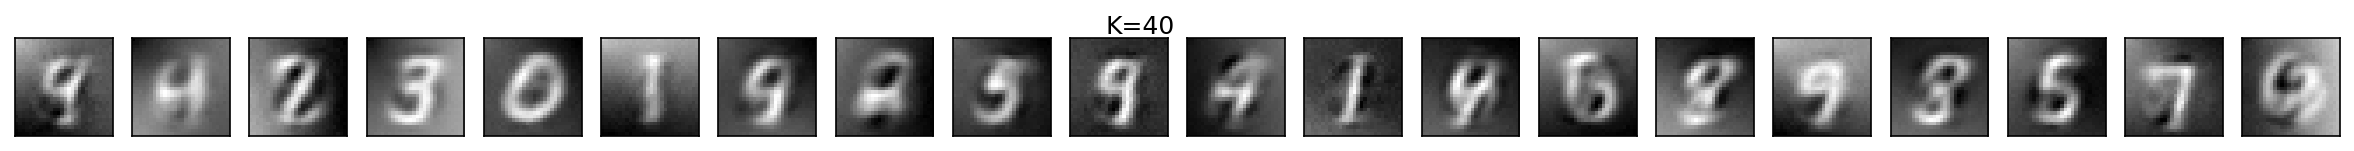

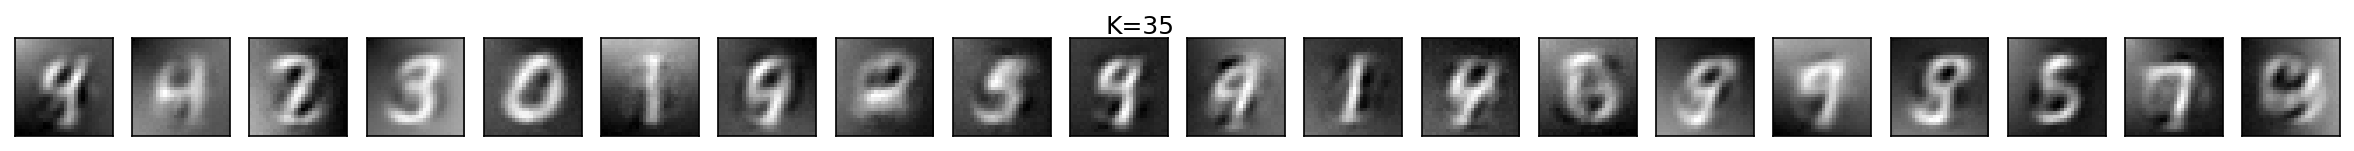

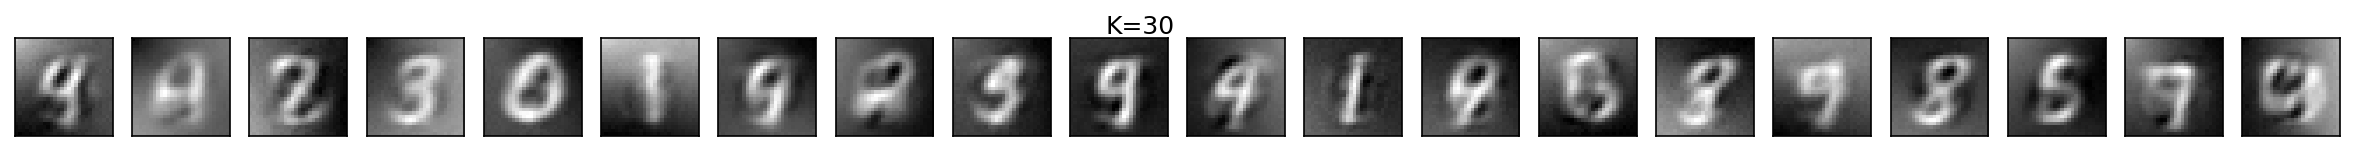

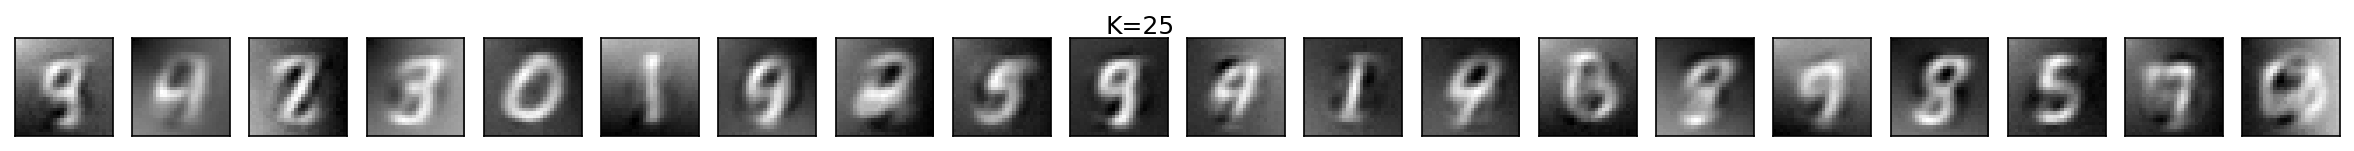

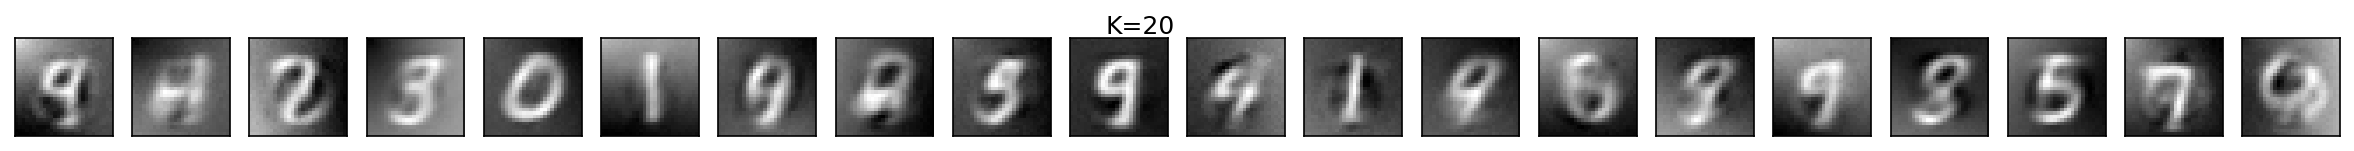

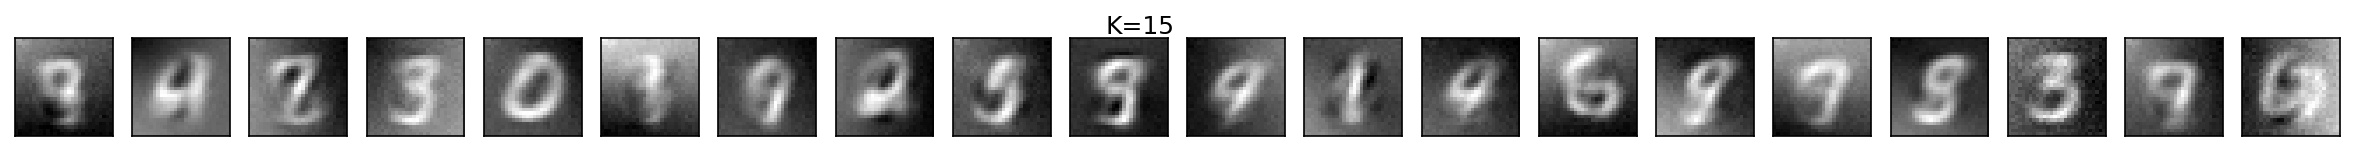

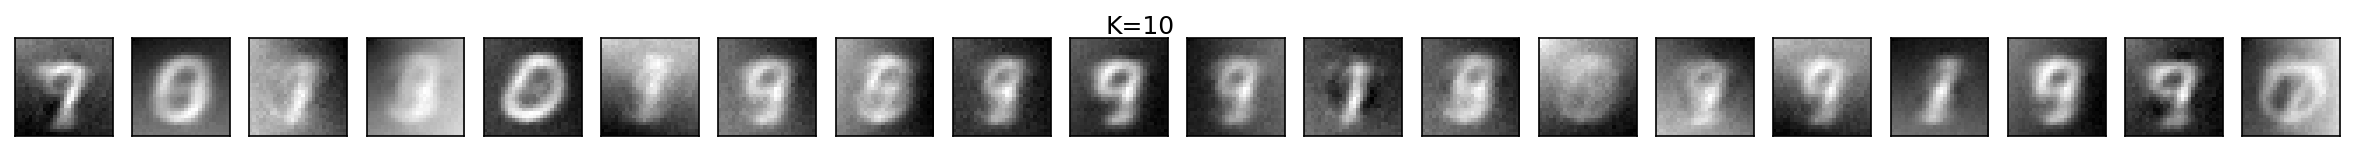

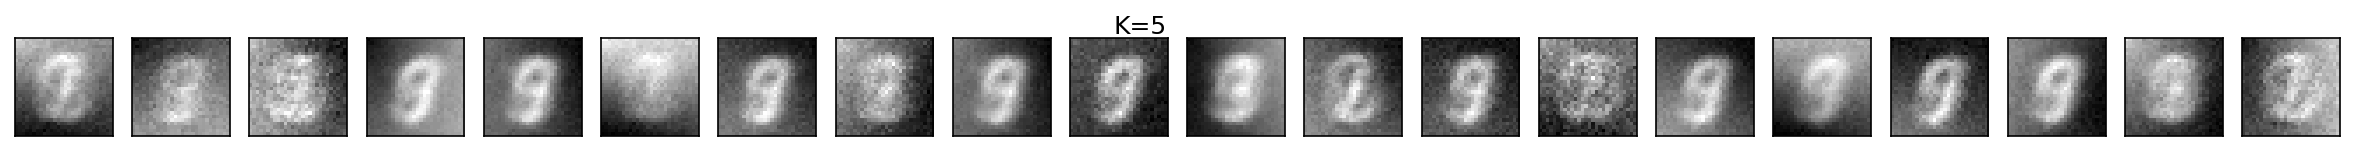

In [ ]:
plot(models_MNIST,test_loader,(1,20))

In [ ]:
root_dir = 'CorruptedFashionMNIST'
data_fashion = pd.read_csv('CorruptedFashionMNIST/Names.csv')
dataset_fashion = FMDataset(dataframe=data_fashion,root_dir=root_dir,transform=transform)

In [ ]:

train_dataset_fashion, test_dataset_fashion = random_split(dataset_fashion, [58000, 2000])
test_loader_fashion = DataLoader(test_dataset_fashion, batch_size=64)

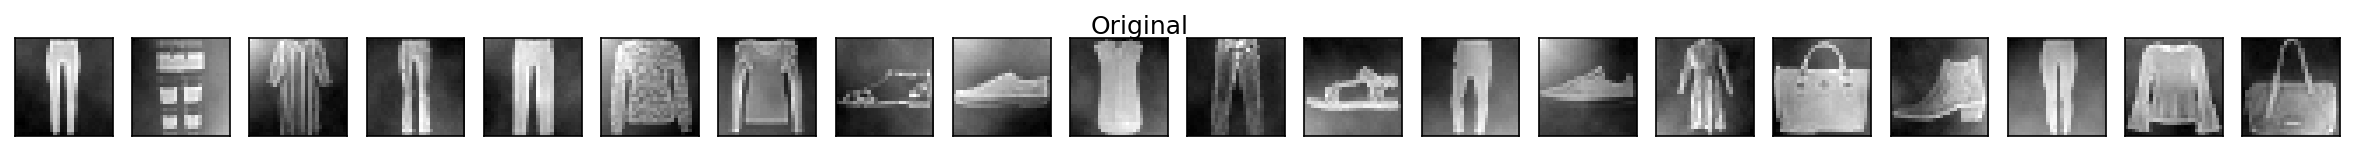

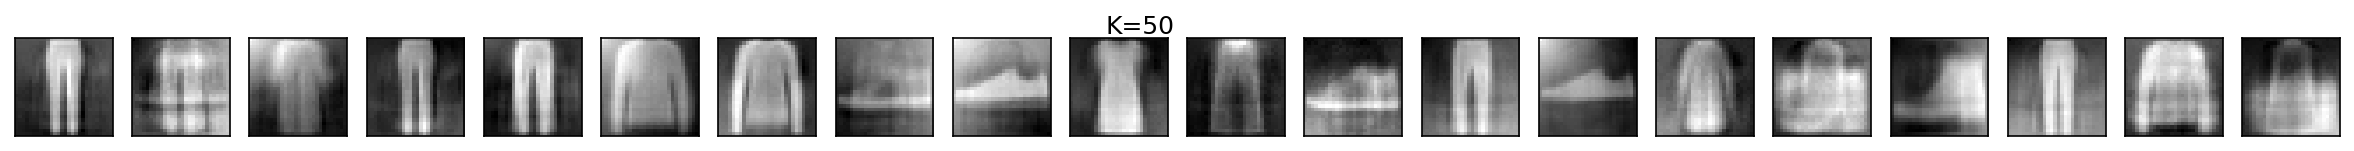

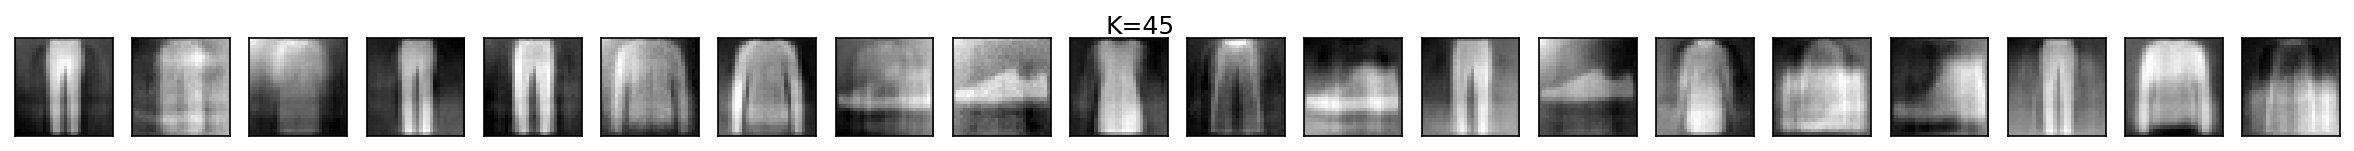

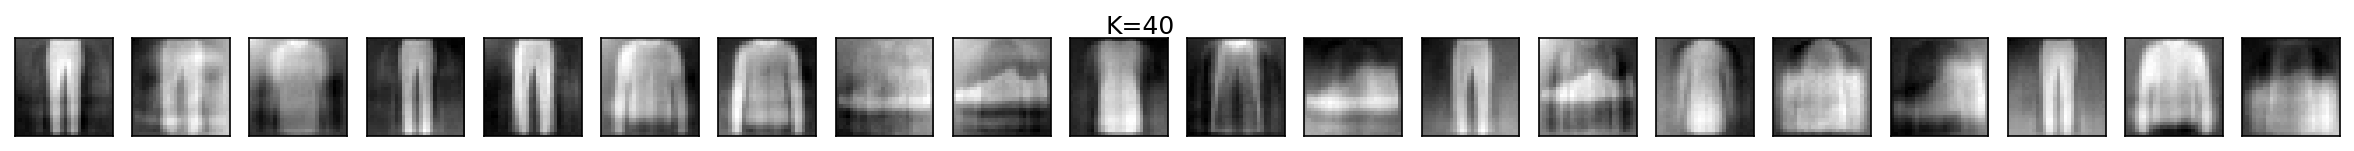

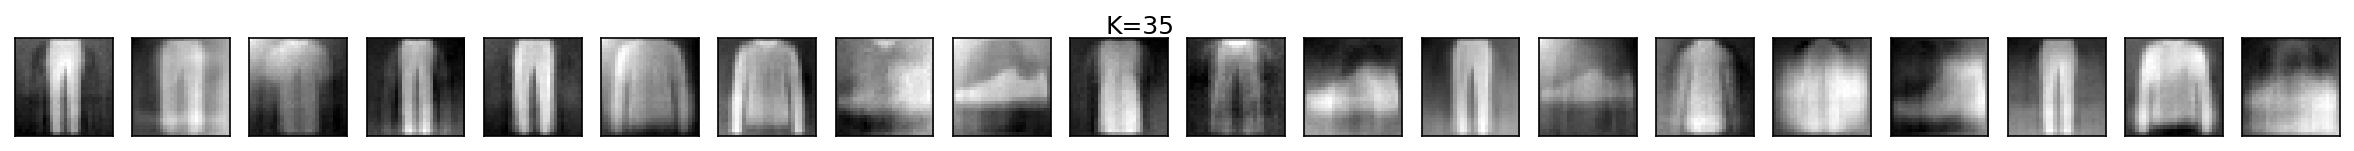

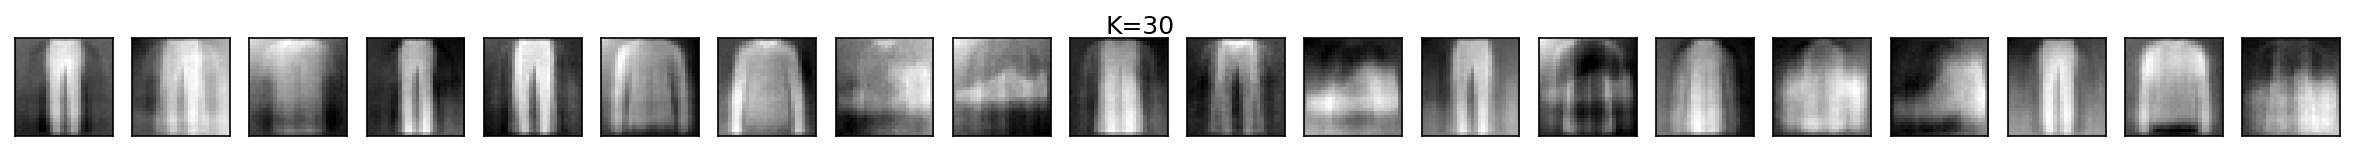

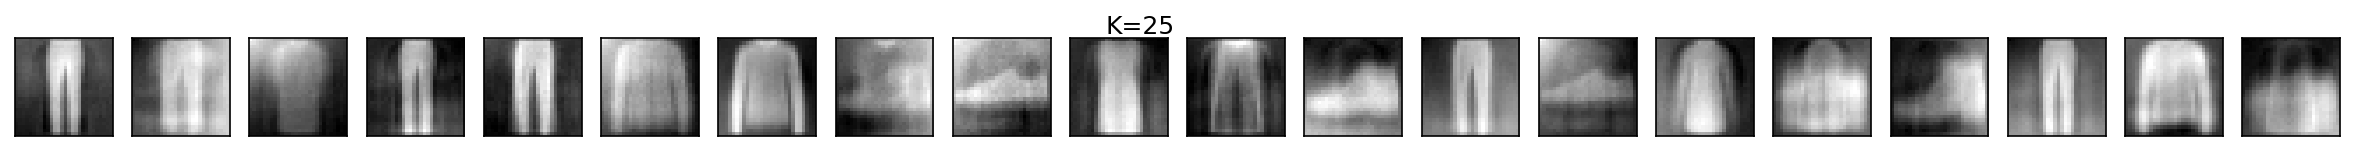

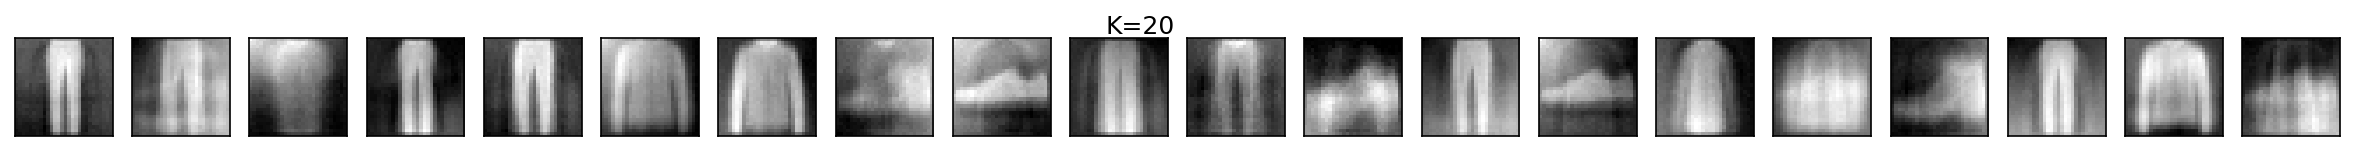

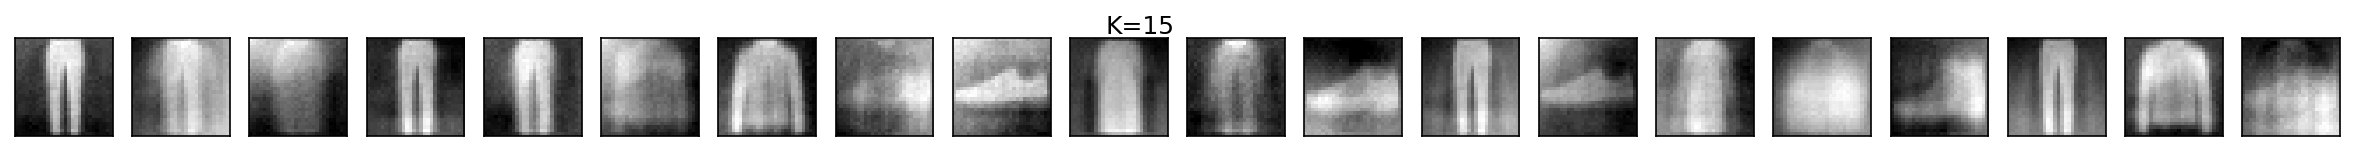

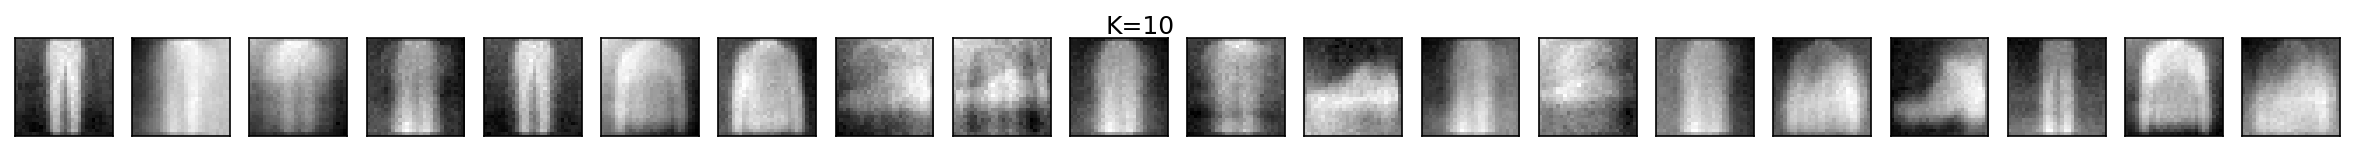

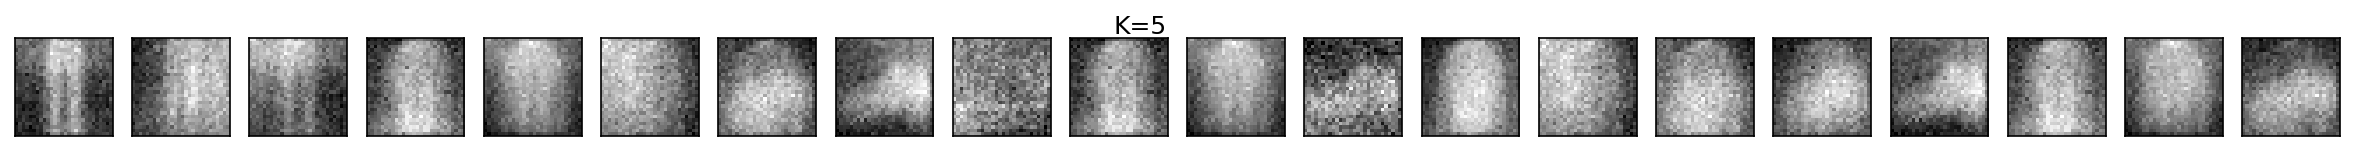

In [ ]:
plot(models_FashionMNIST,test_loader_fashion,(1,20))

In [ ]:
import pickle

os.chdir("/content/drive/MyDrive/GNNProject_K_sparse")
with open("Classifiers/CorruptedMNISTClassifier.pkl", "rb") as f:
    mnist_classifier = pickle.load(f)
with open("Classifiers/CorrputedFashionMNISTClassifier_new.pkl", "rb") as f:
    fashion_classifier = pickle.load(f)

In [ ]:
def transform_t(input):
    input = torch.FloatTensor(np.array(input))
    input = input.type(torch.FloatTensor)
    l=len(input)
    input=input.view(l,-1)
    min, _ = torch.min(input, dim=1, keepdim=True)


    input -= min

    max, _ = torch.max(input, dim=1, keepdim=True)
    input /= max

    return input.view(l,1,28,28)

In [ ]:

def evalmodel_t(model, data_loader, classifier):
    accuracy_list=[]
    with torch.no_grad():

        for images, labels in data_loader:

            reconstructed = model(transform_t(images))
            accuracy = classifier.score(reconstructed.detach().numpy(), labels)

            accuracy_list.append(accuracy)

    return np.mean(accuracy_list)


In [ ]:
accuracy=[]
for k in models_MNIST:
  accuracy_k=evalmodel_t(models_MNIST[k],test_loader,mnist_classifier)
  accuracy.append(accuracy_k)

In [ ]:
accuracy_Fashion=[]
for k in models_FashionMNIST:
  accuracy_k=evalmodel_t(models_FashionMNIST[k],test_loader_fashion,fashion_classifier)
  accuracy_Fashion.append(accuracy_k)

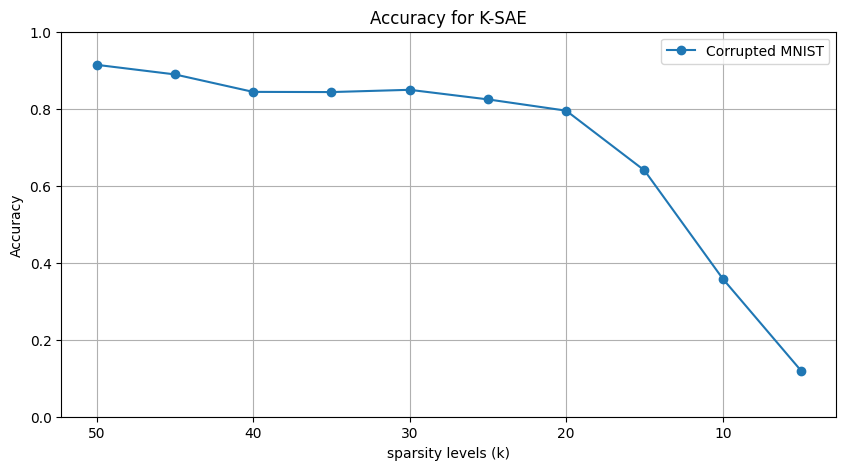

In [4]:
import matplotlib.pyplot as plt

l = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]




plt.figure(figsize=(10, 5))
plt.plot(l, accuracy,  '-o',label='Corrupted MNIST')
#plt.plot(l, accuracy_Fashion, '-o', label='Corrupted FashionMNIST')




plt.title('Accuracy for K-SAE')
plt.xlabel('sparsity levels (k)')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)

plt.gca().invert_xaxis()
plt.ylim(0, 1)

plt.savefig('accuracy_corruptedMNIST.png')
plt.show()
